This notebook intend to keep track of the workflow developped to integrate Sentinel-2 MSI data to the CIDCO Lidar-Bathy project.
Specifically the goal is to add multispectral bottom reflectance data to the geomorphometric CNN algorithm to perform underwater "vegetation" detection and mapping.

In [22]:
import shutil
import subprocess
%matplotlib inline

import urllib

import os
import sys
from zipfile import ZipFile

from sentinelsat import SentinelAPI, read_geojson, geojson_to_wkt
from datetime import date
import geopandas as gpd
import json
import geojson
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import xarray as xr

from shapely.geometry import Polygon, shape

import requests

In [2]:
UserHome = os.path.expanduser("~")
sys.path.append(os.path.join(UserHome,"acolite"))
import acolite as ac

In [3]:
api = SentinelAPI(None, None, 'https://apihub.copernicus.eu/apihub')

As the focus is on coastal benthic ecosystems (especially macrophytes), we can use the 10 meter resolution coastline provided by natural earth (https://www.naturalearthdata.com/downloads/10m-physical-vectors/10m-coastline/). Could use the GSHHG as it is more precise (think so) (http://www.soest.hawaii.edu/pwessel/gshhg/).

In [5]:
Footprint = gpd.read_file('/home/raphael/BenthicReflectance/coastline/ne_10m_coastline.geojson')
Footprint.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

Define an area of interest, here manicouagan peninsula.

In [7]:
polygon = Polygon([(-68.834470, 48.830314), (-68.668047, 49.120927), (-68.008600, 49.366933), (-67.750450, 49.145743), (-68.834470, 48.830314)])
poly_gdf = gpd.GeoDataFrame([1], geometry=[polygon], crs=Footprint.crs)

<Axes: >

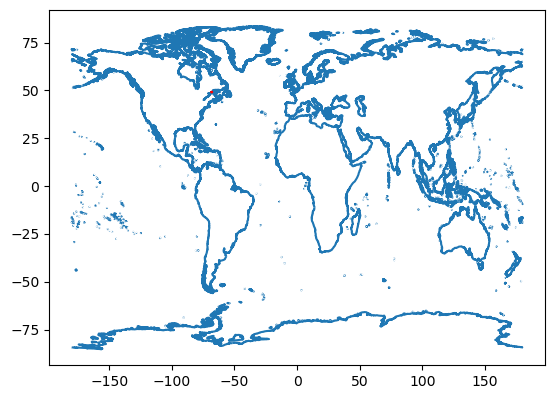

In [8]:
ax = Footprint.plot()
poly_gdf.boundary.plot(ax = ax, color="red")

In [9]:
AOI = Footprint.clip(polygon)

<Axes: >

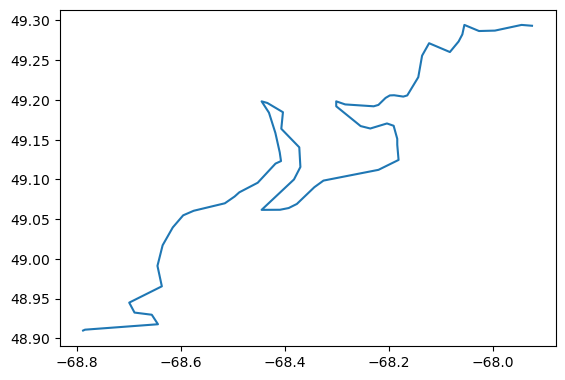

In [10]:
AOI.plot()

In [11]:
AOI_json = AOI.to_json()

In [12]:
AOI_json = json.loads(AOI_json)

In [13]:
AOI_wkt = geojson_to_wkt(AOI_json)

In [14]:
Date = ('20190815', date(2019, 9, 10))
print(Date)

('20190815', datetime.date(2019, 9, 10))


We wrap up the query to the OpenSearch [Solr](https://scihub.copernicus.eu/userguide/5APIsAndBatchScripting#Open_Search)

In [15]:
Products = api.query(AOI_wkt,
                     date=Date,
                     platformname='Sentinel-2',
                     cloudcoverpercentage=(0, 30))

In [17]:
GeoData = api.to_geodataframe(Products)

In [18]:
GeoData[GeoData['processinglevel'] == 'Level-2A']['link_icon'][0]

"https://apihub.copernicus.eu/apihub/odata/v1/Products('add94baa-0583-48cb-b887-59333cbb3b5b')/Products('Quicklook')/$value"

In [ ]:
#r = requests.get(GeoData[GeoData['processinglevel'] == 'Level-2A']['link_icon'][0], allow_redirects=True)

In [21]:
#open('Quicklook.jpg', 'wb').write(r.content)
GeoData[GeoData['processinglevel'] == 'Level-2A']['link_icon'][0]

"https://apihub.copernicus.eu/apihub/odata/v1/Products('add94baa-0583-48cb-b887-59333cbb3b5b')/Products('Quicklook')/$value"

In [25]:
# create a file-like object from the url
f = urllib.request.urlopen("https://apihub.copernicus.eu/apihub/odata/v1/Products('add94baa-0583-48cb-b887-59333cbb3b5b')/Products('Quicklook')/$value")

# read the image file in a numpy array
a = plt.imread(f)
plt.imshow(a)
plt.show()

HTTPError: HTTP Error 401: 

In [26]:
img = mpimg.imread('Quicklook.jpg')
imgplot = plt.imshow(img)
plt.show()

FileNotFoundError: [Errno 2] No such file or directory: 'Quicklook.jpg'

<Axes: >

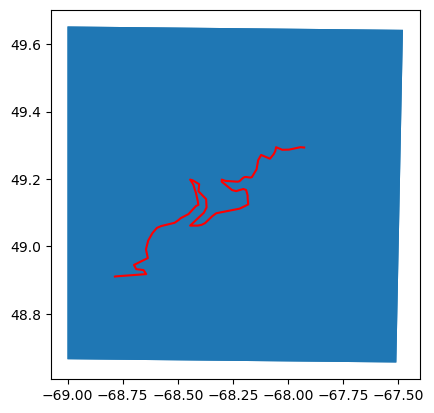

In [27]:
f, ax = plt.subplots(1)
ax = GeoData.plot(ax=ax)

AOI.plot(ax = ax, color = "red")

Create directory to store L1c images, should do that outside of the application directory. In the user home directory ? For dev and test purpose we can ship this MSI image to GitHub.

In [28]:
InputPath = os.path.join(UserHome,"sensor", "MSI", "L1C")

try:
    os.makedirs(InputPath)
except FileExistsError:
    print("FileExistsError")
    pass

Download the image

In [29]:
ID = GeoData[GeoData['processinglevel'] == 'Level-1C']['uuid'][0]

In [30]:
Result = api.download_all(
    products = [ID],
    directory_path = InputPath,
    max_attempts = 10,
    checksum = True,
    n_concurrent_dl = api.concurrent_dl_limit,
    lta_retry_delay = 1800,
    fail_fast = False,
    nodefilter = None
)

MD5 checksumming:   0%|          | 0.00/690M [00:00<?, ?B/s]

Now create a temporary folder to extract the .safe archive and perform the atmospheric correction with ACOLITE.

In [31]:
TmpPath = os.path.join(UserHome, "tmp")

try:
    os.makedirs(TmpPath)
except FileExistsError:
    print("FileExistsError")
    pass

In [33]:
shutil.unpack_archive(Result[0][ID]["path"], TmpPath)

In [34]:
InputFile = os.path.join(os.getcwd(),TmpPath,Result[0][ID]["title"]+".SAFE")

In [35]:
Output = os.path.join(os.getcwd(),TmpPath)

In [36]:
Settings = {"inputfile":InputFile,
            "output":Output,
            "s2_target_res":10,
            "dsf_residual_glint_correction":True}

In [37]:
AcoliteResults = ac.acolite.acolite_run(settings=Settings)

Running ACOLITE processing - Generic GitHub Clone c2023-02-16T16:29:09
Python - linux - 3.10.9 | packaged by conda-forge | (main, Feb  2 2023, 20:20:04) [GCC 11.3.0]
Platform - Linux 5.15.0-60-generic - x86_64 - #66-Ubuntu SMP Fri Jan 20 14:29:49 UTC 2023
Run ID - 20230219_002424
Identified /home/raphael/tmp/S2A_MSIL1C_20190828T153601_N0208_R111_T19UEQ_20190828T204636.SAFE as Sentinel-2 type
Starting conversion of 1 scenes
Starting conversion of /home/raphael/tmp/S2A_MSIL1C_20190828T153601_N0208_R111_T19UEQ_20190828T204636.SAFE
Importing metadata from L1C_T19UEQ_A021844_20190828T153558
Reading per pixel geometry
Computing band average per detector geometry
Detector 1


/home/raphael/acolite/acolite/sentinel2/l1_convert.py:415: RuntimeWarning: Mean of empty slice
  ave_vza = np.nanmean(ave_vza, axis=2)
/home/raphael/acolite/acolite/sentinel2/l1_convert.py:416: RuntimeWarning: Mean of empty slice
  ave_vaa = np.nanmean(ave_vaa, axis=2)


Detector 2
Detector 3
Detector 4
Detector 5
Detector 6
Detector 7
Wrote raa (10980, 10980)
Wrote vza (10980, 10980)
Wrote sza (10980, 10980)
Writing geolocation lon/lat
(10980, 10980)
Wrote lon
(10980, 10980)
Wrote lat
Converting bands
Converting bands: Wrote rhot_443 ((10980, 10980))
Converting bands: Wrote rhot_492 ((10980, 10980))
Converting bands: Wrote rhot_560 ((10980, 10980))
Converting bands: Wrote rhot_665 ((10980, 10980))
Converting bands: Wrote rhot_704 ((10980, 10980))
Converting bands: Wrote rhot_740 ((10980, 10980))
Converting bands: Wrote rhot_783 ((10980, 10980))
Converting bands: Wrote rhot_833 ((10980, 10980))
Converting bands: Wrote rhot_865 ((10980, 10980))
Converting bands: Wrote rhot_945 ((10980, 10980))
Converting bands: Wrote rhot_1373 ((10980, 10980))
Converting bands: Wrote rhot_1614 ((10980, 10980))
Converting bands: Wrote rhot_2202 ((10980, 10980))
Conversion took 395.3 seconds
Created /home/raphael/tmp/S2A_MSI_2019_08_28_15_39_27_T19UEQ_L1R.nc
Wrote /home/r

In [42]:
AcoliteResults[0]["l2r"][0]

'/home/raphael/tmp/S2A_MSI_2019_08_28_15_39_27_T19UEQ_L2R.nc'

In [43]:
L2 = xr.open_dataset(AcoliteResults[0]["l2r"][0])

In [44]:
L2

<xarray.Dataset>
Dimensions:              (x: 10980, y: 10980)
Coordinates:
  * x                    (x) float64 5e+05 5e+05 5e+05 ... 6.098e+05 6.098e+05
  * y                    (y) float64 5.5e+06 5.5e+06 ... 5.39e+06 5.39e+06
Data variables: (12/30)
    transverse_mercator  float64 ...
    lon                  (y, x) float32 ...
    lat                  (y, x) float32 ...
    sza                  (y, x) float32 ...
    vza                  (y, x) float32 ...
    raa                  (y, x) float32 ...
    ...                   ...
    rhot_945             (y, x) float32 ...
    rhot_1373            (y, x) float32 ...
    rhot_1614            (y, x) float32 ...
    rhos_1614            (y, x) float32 ...
    rhot_2202            (y, x) float32 ...
    rhos_2202            (y, x) float32 ...
Attributes: (12/330)
    generated_by:                              ACOLITE
    generated_on:                              2023-02-19 00:25:31 UTC
    contact:                                   Quinten Vanhellemont
    product_type:                              NetCDF
    metadata_profile:                          beam
    metadata_version:                          0.5
    ...                                        ...
    reproject_inputfile_force:                 False
    luts:                                      ['ACOLITE-LUT-202110-MOD1', 'A...
    luts_pressures:                            [ 500  750 1013 1100]
    slicing:                                   False
    inputfile:                                 /home/raphael/tmp/S2A_MSIL1C_2...
    runid:                                     20230219_002424